<a href="https://colab.research.google.com/github/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/blob/main/IAP_T2_E1_JJTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Nacional Autónoma de México
# Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
# Introducción al Aprendizaje Profundo
# José de Jesús Tapia López
# Tarea 2: Redes Convolucionales
# 11 de Mayo de 2021

## Ejercicio 1

Diseña y entrena una red convolucional para el conjunto de datos CIFAR10. Explora diferentes diseños buscando mejorar tus resultados en el ejercicio 4 de la tarea 1. Discute tus resultados.

In [2]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

In [3]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# procesamiento de imágenes
from skimage import io
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as tvm
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm import trange

In [4]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8

# CIFAR-10 classes
CLASSES = {0:'airplane',1:'car',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # desnormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal 
    ### SE LE AGREGÓ EL NÚMERO DE CANALES DE UNA
    ### IMAGEN EN RGB, EL CUAL ES 3
    x = x.reshape(*x.shape[:3],3)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

def set_seed(seed=171299):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

In [5]:
# creamos el Dataset
ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)


Extracting ../data/cifar-10-python.tar.gz to ../data


images[0] shape=(32, 32, 3) dtype=uint8


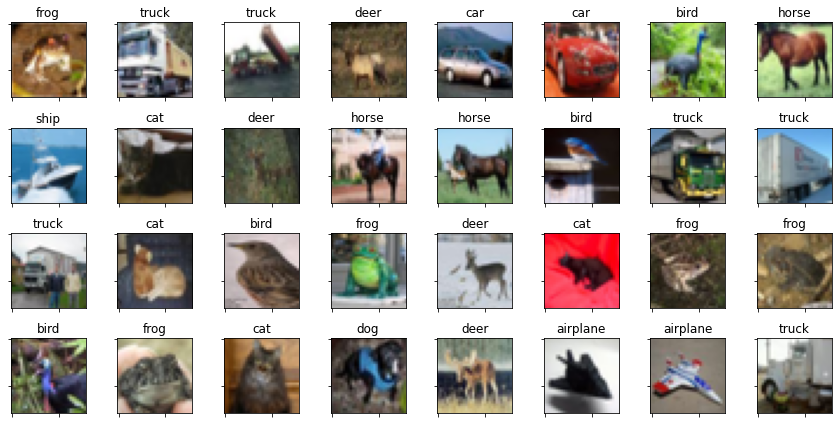

In [6]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [CLASSES[y] for y in labels]
display_grid(images, titles, ROWS, COLS)

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


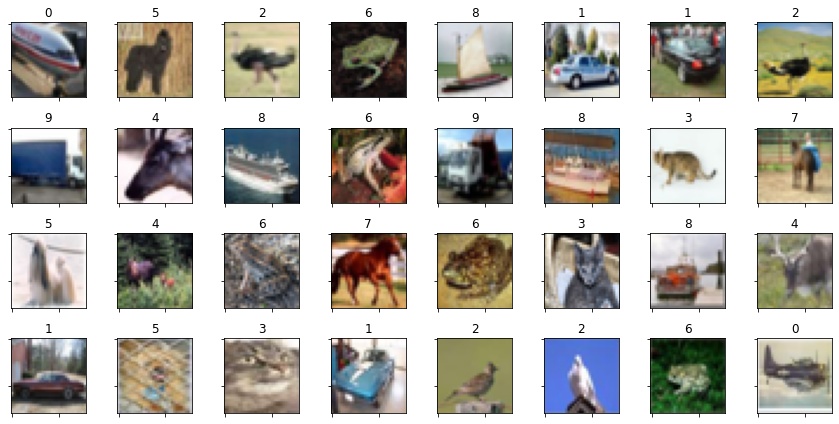

In [7]:
### Entrenamiento

# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


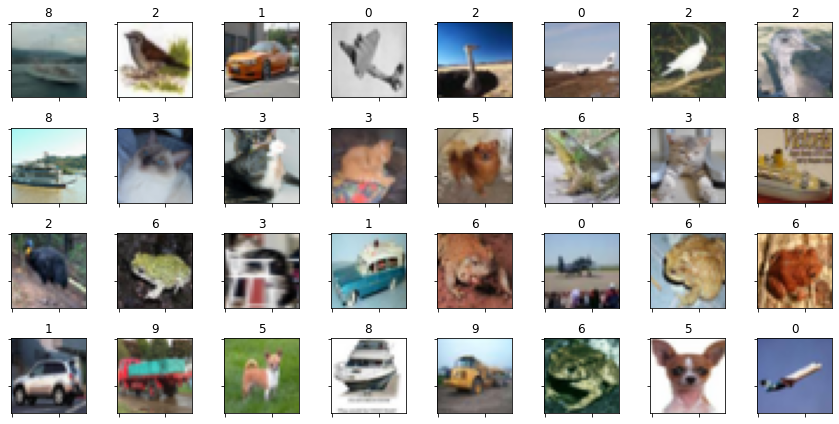

In [8]:
### Prueba

# creamos un Dataset
tst_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

### Arquitectura 1: CNN

Para este primer intento utilizamos el optimizador Adam. Es importante recordar que ahora las imágenes son de 32x32 con 3 canales.

En todas las arquitecturas, usaré la GPU que proprociona colab.

In [ ]:
# definición del arquitectura
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 12 * 16 * 16

        # definición de bloques conv
        # [M, 3, 32, 32] => [M, 12, 16, 16]
        self.cnn = nn.Sequential(

            # bloque conv1
            # [M, 3, 32, 32] => [M, 12, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=12, 
                      kernel_size=3, padding=1),
            # [M, 12, 32, 32]
            nn.ReLU(),
            # [M, 12, 32, 32] => [M, 12, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )       
        
        # [M, 12, 16, 16] => [M, 12x16x16]
        self.flatten = nn.Flatten()

        # [M, 12x16x16] => [M, 10]
        self.cls = nn.Linear(self.num_feats, 10)
    
    # metodo para inferencia
    def forward(self, x):
        # [M, 3, 32, 32] => [M, 12, 16, 16]
        x = self.cnn(x)
        # [M, 12, 16, 16] => [M, 12x16x16]
        x = self.flatten(x)
        # [M, 12x16x16] => [M, 10]
        x = self.cls(x)
        return x

#### Instancia de la arquitectura

In [ ]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=3072, out_features=10, bias=True)
)


In [ ]:
# inferencia con datos sintéticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


In [ ]:
summary(model, (1, 3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 12, 16, 16]           --
|    └─Conv2d: 2-1                       [1, 12, 32, 32]           336
|    └─ReLU: 2-2                         [1, 12, 32, 32]           --
|    └─MaxPool2d: 2-3                    [1, 12, 16, 16]           --
├─Flatten: 1-2                           [1, 3072]                 --
├─Linear: 1-3                            [1, 10]                   30,730
Total params: 31,066
Trainable params: 31,066
Non-trainable params: 0
Total mult-adds (M): 0.37
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.12
Estimated Total Size (MB): 0.23

#### Ciclo de entrenamiento

In [14]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist


In [ ]:
# instanciamos un modelo
model = CNN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl)


  5%|▌         | 1/20 [00:30<09:42, 30.68s/it]

E00 loss=[140.82,142.72] acc=[51.01,49.64]


 10%|█         | 2/20 [01:00<09:07, 30.43s/it]

E01 loss=[125.29,130.11] acc=[56.48,53.65]


 15%|█▌        | 3/20 [01:30<08:33, 30.22s/it]

E02 loss=[117.45,124.48] acc=[59.29,56.35]


 20%|██        | 4/20 [01:59<08:00, 30.06s/it]

E03 loss=[113.84,122.41] acc=[60.41,57.16]


 25%|██▌       | 5/20 [02:29<07:30, 30.01s/it]

E04 loss=[109.83,119.65] acc=[62.03,58.40]


 30%|███       | 6/20 [02:59<06:58, 29.92s/it]

E05 loss=[106.99,118.24] acc=[63.11,58.70]


 35%|███▌      | 7/20 [03:28<06:26, 29.76s/it]

E06 loss=[106.10,118.91] acc=[63.33,58.51]


 40%|████      | 8/20 [03:58<05:56, 29.71s/it]

E07 loss=[107.32,121.45] acc=[62.35,57.24]


 45%|████▌     | 9/20 [04:28<05:26, 29.68s/it]

E08 loss=[102.53,118.28] acc=[64.64,59.24]


 50%|█████     | 10/20 [04:57<04:56, 29.63s/it]

E09 loss=[104.65,120.53] acc=[63.44,57.69]


 55%|█████▌    | 11/20 [05:27<04:26, 29.65s/it]

E10 loss=[103.55,120.89] acc=[64.09,57.91]


 60%|██████    | 12/20 [05:57<03:57, 29.65s/it]

E11 loss=[ 99.30,117.53] acc=[65.73,59.38]


 65%|██████▌   | 13/20 [06:26<03:27, 29.68s/it]

E12 loss=[ 98.93,117.85] acc=[65.71,59.58]


 70%|███████   | 14/20 [06:56<02:57, 29.65s/it]

E13 loss=[ 96.54,116.88] acc=[66.64,59.69]


 75%|███████▌  | 15/20 [07:26<02:28, 29.72s/it]

E14 loss=[ 97.10,118.47] acc=[66.20,59.14]


 80%|████████  | 16/20 [07:56<01:59, 29.81s/it]

E15 loss=[ 96.36,118.21] acc=[66.89,59.40]


 85%|████████▌ | 17/20 [08:26<01:29, 29.84s/it]

E16 loss=[ 97.43,120.10] acc=[66.43,58.96]


 90%|█████████ | 18/20 [08:55<00:59, 29.82s/it]

E17 loss=[ 94.92,118.10] acc=[67.17,59.46]


 95%|█████████▌| 19/20 [09:25<00:29, 29.79s/it]

E18 loss=[ 95.29,119.09] acc=[67.00,59.38]


100%|██████████| 20/20 [09:55<00:00, 29.78s/it]

E19 loss=[ 92.79,118.04] acc=[68.13,59.87]


#### Gráficas de pérdidas y exactitud

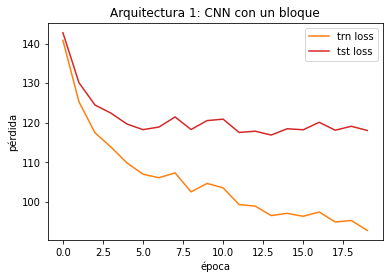

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.title('Arquitectura 1: CNN con un bloque')
plt.show()

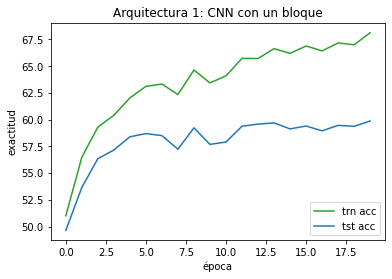

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.title('Arquitectura 1: CNN con un bloque')
plt.show()

#### Evaluación

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 92.78,117.97] acc=[68.13,59.92]


Los resultados que obtendremos en esta libreta los vamos a comparar con los que conseguimos en la tarea 1.

De los resultados y las gráficas anteriores, podemos observar que con una notable menor cantidad de parámetros, obtuvimos un mejor rendimiento utilizando CNN, tanto en pérdida como en accuracy (En la tarea 1 obtuvimos: **loss=[155.01,157.43]**; **acc=[46.14,45.09]**). Desafortunadamente, en las figuras pasadas parecer que hay un poco de sobreajuste en el modelo.

### Arquitectura 2: CNN con dos bloques

Para este segundo intento, vamos a hacerlo con dos bloques e igualmente utilizando el optimizador Adam.

In [9]:
# definición de la segunda arquitectura (la que tiene dos bloques)
class CNN2(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN2, self).__init__()
        self.num_feats = 12 * 16 * 16

        # definición de bloques conv
        # [M, 3, 32, 32] => [M, 48, 8, 8]
        self.cnn = nn.Sequential(

            # bloque conv1
            # [M, 3, 32, 32] => [M, 12, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=12, 
                      kernel_size=3, padding=1),
            # [M, 12, 32, 32]
            nn.ReLU(),
            # [M, 12, 32, 32] => [M, 12, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),

            # bloque conv2
            # [[M, 12, 16, 16] => [M, 48, 16, 16]
            nn.Conv2d(in_channels=12, out_channels=48, 
                      kernel_size=3, padding=1),
            # [M, 48, 16, 16]
            nn.ReLU(),
            # [M, 48, 16, 16] => [M, 48, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )       
        
        # [M, 48, 8, 8] => [M, 48x8x8]
        self.flatten = nn.Flatten()

        # [M, 48x8x8] => [M, 10]
        self.cls = nn.Linear(self.num_feats, 10)
    
    # metodo para inferencia
    def forward(self, x):
        # [M, 3, 32, 32] => [M, 48, 8, 8]
        x = self.cnn(x)
        # [M, 48, 8, 8]] => [M, 48x8x8]
        x = self.flatten(x)
        # [M, 48x8x8] => [M, 10]
        x = self.cls(x)
        return x

In [10]:
model2 = CNN2()
print(model2)

CNN2(
  (cnn): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=3072, out_features=10, bias=True)
)


In [11]:
# inferencia con datos sintéticos
y2 = model2(x)
print(f'{x.shape} => {y2.shape}')

torch.Size([32, 3, 32, 32]) => torch.Size([32, 10])


In [12]:
summary(model2, (1, 3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
CNN2                                     --                        --
├─Sequential: 1-1                        [1, 48, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 12, 32, 32]           336
│    └─ReLU: 2-2                         [1, 12, 32, 32]           --
│    └─MaxPool2d: 2-3                    [1, 12, 16, 16]           --
│    └─Conv2d: 2-4                       [1, 48, 16, 16]           5,232
│    └─ReLU: 2-5                         [1, 48, 16, 16]           --
│    └─MaxPool2d: 2-6                    [1, 48, 8, 8]             --
├─Flatten: 1-2                           [1, 3072]                 --
├─Linear: 1-3                            [1, 10]                   30,730
Total params: 36,298
Trainable params: 36,298
Non-trainable params: 0
Total mult-adds (M): 1.95
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 0.15
Estimated Total Size (MB): 0.35

In [15]:
# instanciamos un modelo
model2 = CNN2()
# entrenamos
loss_hist2, acc_hist2 = train(model2, trn_dl, tst_dl)

  5%|▌         | 1/20 [00:58<18:36, 58.74s/it]

E00 loss=[122.93,125.37] acc=[57.48,56.00]


 10%|█         | 2/20 [01:57<17:39, 58.89s/it]

E01 loss=[105.07,110.41] acc=[63.86,61.39]


 15%|█▌        | 3/20 [02:56<16:41, 58.90s/it]

E02 loss=[ 97.97,105.93] acc=[66.09,63.31]


 20%|██        | 4/20 [03:57<15:49, 59.33s/it]

E03 loss=[ 91.39,102.06] acc=[68.37,64.71]


 25%|██▌       | 5/20 [04:56<14:50, 59.36s/it]

E04 loss=[ 85.30, 98.35] acc=[70.65,66.02]


 30%|███       | 6/20 [05:56<13:54, 59.63s/it]

E05 loss=[ 79.46, 95.00] acc=[72.49,67.44]


 35%|███▌      | 7/20 [06:56<12:55, 59.63s/it]

E06 loss=[ 75.10, 93.60] acc=[74.21,68.26]


 40%|████      | 8/20 [07:56<11:55, 59.62s/it]

E07 loss=[ 73.05, 93.48] acc=[74.90,68.12]


 45%|████▌     | 9/20 [08:55<10:54, 59.47s/it]

E08 loss=[ 69.18, 93.22] acc=[76.58,68.78]


 50%|█████     | 10/20 [09:53<09:51, 59.16s/it]

E09 loss=[ 67.63, 93.53] acc=[76.67,68.82]


 55%|█████▌    | 11/20 [10:52<08:51, 59.05s/it]

E10 loss=[ 69.94, 97.13] acc=[75.27,67.49]


 60%|██████    | 12/20 [11:51<07:51, 58.95s/it]

E11 loss=[ 65.36, 97.27] acc=[77.47,67.60]


 65%|██████▌   | 13/20 [12:52<06:57, 59.70s/it]

E12 loss=[ 60.15, 93.41] acc=[79.49,69.31]


 70%|███████   | 14/20 [13:53<06:01, 60.18s/it]

E13 loss=[ 61.53, 97.09] acc=[78.67,68.68]


 75%|███████▌  | 15/20 [14:54<05:01, 60.22s/it]

E14 loss=[ 56.41, 94.81] acc=[80.80,69.80]


 80%|████████  | 16/20 [15:54<04:00, 60.09s/it]

E15 loss=[ 59.47,100.02] acc=[79.35,68.34]


 85%|████████▌ | 17/20 [16:52<02:58, 59.61s/it]

E16 loss=[ 54.96, 98.29] acc=[81.11,69.06]


 90%|█████████ | 18/20 [17:50<01:58, 59.06s/it]

E17 loss=[ 53.55, 99.22] acc=[81.43,68.51]


 95%|█████████▌| 19/20 [18:47<00:58, 58.37s/it]

E18 loss=[ 53.19,100.53] acc=[81.50,68.45]


100%|██████████| 20/20 [19:44<00:00, 59.21s/it]

E19 loss=[ 53.14,102.51] acc=[81.64,68.03]


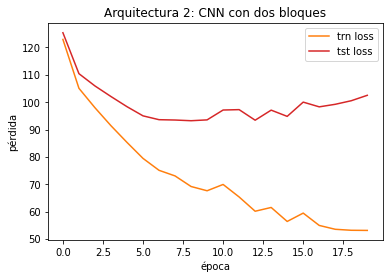

In [21]:
trn_loss2, tst_loss2 = zip(*loss_hist2)
plt.plot(trn_loss2, 'tab:orange', label='trn loss')
plt.plot(tst_loss2, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.title('Arquitectura 2: CNN con dos bloques')
plt.show()

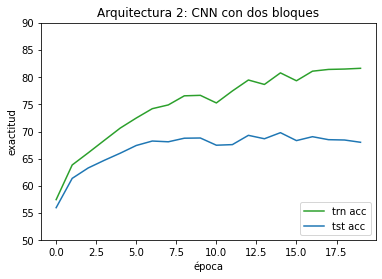

In [20]:
trn_acc2, tst_acc2 = zip(*acc_hist2)
plt.plot(trn_acc2, 'tab:green', label='trn acc')
plt.plot(tst_acc2, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.ylim(50,90)
plt.title('Arquitectura 2: CNN con dos bloques')
plt.show()


In [18]:
# evaluamos en entrenamiento
trn_loss2, trn_acc2 = eval_epoch(trn_dl, model2)
# evaluamos en prueba
tst_loss2, tst_acc2 = eval_epoch(tst_dl, model2)
print(f'loss=[{trn_loss2:6.2f},{tst_loss2:6.2f}] '
      f'acc=[{trn_acc2:5.2f},{tst_acc2:5.2f}]')

loss=[ 53.14,102.58] acc=[81.64,68.00]


En cuanto a este segundo intento, notamos de los resultados y las gráficas anteriores que mejoró el accuracy y disminuyó la pérdida utilizando dos bloques. Nuevamente la desventaja es que aquí también hubo un sobreajuste. En cuanto a tiempo, vemos que se tardó prácticamente el doble que con la primera arquitectura.

### Arquitectura 3: CNN con tres bloques

In [ ]:
# definición de la tercera arquitectura (la que tiene tres bloques)
class CNN3(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN3, self).__init__()
        self.num_feats = 12 * 16 * 16

        # definición de bloques conv
        # [M, 3, 32, 32] => [M, 192, 4, 4]
        self.cnn = nn.Sequential(

            # bloque conv1
            # [M, 3, 32, 32] => [M, 12, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=12, 
                      kernel_size=3, padding=1),
            # [M, 12, 32, 32]
            nn.ReLU(),
            # [M, 12, 32, 32] => [M, 12, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),

            # bloque conv2
            # [[M, 12, 16, 16] => [M, 48, 16, 16]
            nn.Conv2d(in_channels=12, out_channels=48, 
                      kernel_size=3, padding=1),
            # [M, 48, 16, 16]
            nn.ReLU(),
            # [M, 48, 16, 16] => [M, 48, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),

            # bloque conv3
            # [M, 48, 8, 8] => [M, 192, 8, 8]
            nn.Conv2d(in_channels=48, out_channels=192, 
                      kernel_size=3, padding=1),
            # [M, 192, 8, 8]
            nn.ReLU(),
            # [M, 192, 8, 8] => [M, 192, 4, 4]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )       
        
        # [M, 192, 4, 4] => [M, 192x4x4]
        self.flatten = nn.Flatten()

        # [M, 192x4x4] => [M, 10]
        self.cls = nn.Linear(self.num_feats, 10)
    
    # metodo para inferencia
    def forward(self, x):
        # [M, 3, 32, 32] => [M, 192, 4, 4]
        x = self.cnn(x)
        # [M, 192, 4, 4] => [M, 192x4x4]
        x = self.flatten(x)
        # [M, 192x4x4] => [M, 10]
        x = self.cls(x)
        return x

In [ ]:
model3 = CNN3()
print(model3)

CNN3(
  (cnn): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=3072, out_features=10, bias=True)
)


In [ ]:
# inferencia con datos sintéticos
y3 = model3(x)
print(f'{x.shape} => {y3.shape}')

torch.Size([32, 3, 32, 32]) => torch.Size([32, 10])


In [ ]:
summary(model3, (1, 3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 192, 4, 4]            --
|    └─Conv2d: 2-1                       [1, 12, 32, 32]           336
|    └─ReLU: 2-2                         [1, 12, 32, 32]           --
|    └─MaxPool2d: 2-3                    [1, 12, 16, 16]           --
|    └─Conv2d: 2-4                       [1, 48, 16, 16]           5,232
|    └─ReLU: 2-5                         [1, 48, 16, 16]           --
|    └─MaxPool2d: 2-6                    [1, 48, 8, 8]             --
|    └─Conv2d: 2-7                       [1, 192, 8, 8]            83,136
|    └─ReLU: 2-8                         [1, 192, 8, 8]            --
|    └─MaxPool2d: 2-9                    [1, 192, 4, 4]            --
├─Flatten: 1-2                           [1, 3072]                 --
├─Linear: 1-3                            [1, 10]                   30,730
Total params: 119,434
Trainable params: 119,434
Non-trainable params: 0
T

In [ ]:
# instanciamos un modelo
model3 = CNN3()
# entrenamos
loss_hist3, acc_hist3 = train(model3, trn_dl, tst_dl)


  5%|▌         | 1/20 [01:31<28:56, 91.38s/it]

E00 loss=[120.20,122.50] acc=[57.26,55.76]



 10%|█         | 2/20 [03:02<27:25, 91.44s/it]

E01 loss=[ 95.72,101.77] acc=[66.58,64.00]



 15%|█▌        | 3/20 [04:33<25:51, 91.29s/it]

E02 loss=[ 80.86, 91.57] acc=[71.90,68.35]



 20%|██        | 4/20 [06:06<24:27, 91.70s/it]

E03 loss=[ 70.73, 85.69] acc=[75.97,70.37]



 25%|██▌       | 5/20 [07:39<22:59, 91.95s/it]

E04 loss=[ 69.40, 89.50] acc=[75.89,69.42]



 30%|███       | 6/20 [09:11<21:27, 91.99s/it]

E05 loss=[ 57.05, 82.45] acc=[80.88,71.57]



 35%|███▌      | 7/20 [10:43<19:55, 91.95s/it]

E06 loss=[ 50.84, 82.64] acc=[82.81,72.01]



 40%|████      | 8/20 [12:12<18:15, 91.31s/it]

E07 loss=[ 47.93, 84.03] acc=[83.70,72.48]



 45%|████▌     | 9/20 [13:43<16:41, 91.07s/it]

E08 loss=[ 44.04, 88.35] acc=[84.80,72.22]



 50%|█████     | 10/20 [15:15<15:15, 91.52s/it]

E09 loss=[ 38.96, 89.16] acc=[86.71,72.38]



 55%|█████▌    | 11/20 [16:50<13:52, 92.51s/it]

E10 loss=[ 35.14, 91.70] acc=[88.08,72.00]



 60%|██████    | 12/20 [18:23<12:19, 92.48s/it]

E11 loss=[ 30.40, 96.30] acc=[89.70,72.14]



 65%|██████▌   | 13/20 [19:55<10:48, 92.58s/it]

E12 loss=[ 25.66, 99.06] acc=[91.66,72.37]



 70%|███████   | 14/20 [21:28<09:16, 92.67s/it]

E13 loss=[ 24.39,103.53] acc=[91.90,72.14]



 75%|███████▌  | 15/20 [23:02<07:44, 93.00s/it]

E14 loss=[ 20.48,109.66] acc=[93.30,72.10]



 80%|████████  | 16/20 [24:36<06:13, 93.33s/it]

E15 loss=[ 20.16,117.47] acc=[92.97,71.60]



 85%|████████▌ | 17/20 [26:10<04:40, 93.49s/it]

E16 loss=[ 18.56,122.65] acc=[93.45,71.53]



 90%|█████████ | 18/20 [27:42<03:06, 93.10s/it]

E17 loss=[ 18.51,132.21] acc=[93.50,70.48]



 95%|█████████▌| 19/20 [29:16<01:33, 93.22s/it]

E18 loss=[ 14.29,136.01] acc=[95.26,70.79]



100%|██████████| 20/20 [30:52<00:00, 92.60s/it]

E19 loss=[ 12.52,140.09] acc=[95.75,71.10]


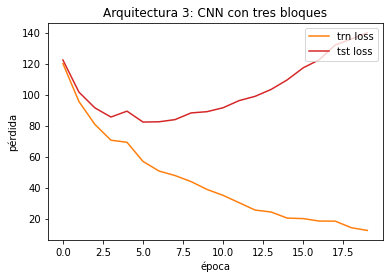

In [ ]:
trn_loss3, tst_loss3 = zip(*loss_hist3)
plt.plot(trn_loss3, 'tab:orange', label='trn loss')
plt.plot(tst_loss3, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.title('Arquitectura 3: CNN con tres bloques')
plt.show()

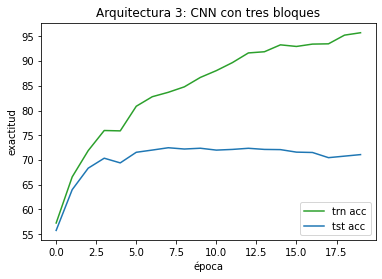

In [ ]:
trn_acc3, tst_acc3 = zip(*acc_hist3)
plt.plot(trn_acc3, 'tab:green', label='trn acc')
plt.plot(tst_acc3, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.title('Arquitectura 3: CNN con tres bloques')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss3, trn_acc3 = eval_epoch(trn_dl, model3)
# evaluamos en prueba
tst_loss3, tst_acc3 = eval_epoch(tst_dl, model3)
print(f'loss=[{trn_loss3:6.2f},{tst_loss3:6.2f}] '
      f'acc=[{trn_acc3:5.2f},{tst_acc3:5.2f}]')

loss=[ 12.53,139.94] acc=[95.74,71.11]


Parece ser que conforme aumentamos los bloques, el accuracy  fue mejorando. Sin embargo, aquí sí fue más notable el sobreajuste, principlamente en la gráfica relacionada a la pérdida en cada época, vemos que difiere mucho en los datos de entrenamiento y en los de prueba (en estos últimos es muy alta). La otra desventaja es que se tardó mucho tiempo la ejecución y fueron más los parámetros que en las arquitecturas anteriores.

### Arquitectura 4: MicroInception

In [ ]:
class InceptionBlock(nn.Module):

    def __init__(self, in_channels, 
                 out_channels1, out_channels3):
        super(InceptionBlock, self).__init__()
        out_channels31, out_channels32 = out_channels3

        # bifurcacion 1
        # [N, I, H, W] => [N, O1, H, W]
        self.cnn_branch1 = nn.Conv2d(in_channels=in_channels, 
                                    out_channels=out_channels1, 
                                    kernel_size=1)

        # bifurcacion 3
        # [N, I, H, W] => [N, O32, H, W]
        self.cnn_branch3 = nn.Sequential(
            # conv1
            # [N, I, H, W] => [N, O31, H, W]
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels31, 
                      kernel_size=1),
            # [N, O31, H, W]
            nn.ReLU(),
          
            # conv2
            # [N, O31, H, W] => [N, O32, H, W]
            nn.Conv2d(in_channels=out_channels31, 
                      out_channels=out_channels32,
                      kernel_size=5, padding=2),
        )

    def forward(self, x):
        # [N, I, H, W] => [N, O1, H, W]
        x1 = self.cnn_branch1(x)
        # [N, I, H, W] => [N, O32, H, W]
        x3 = self.cnn_branch3(x)
        # O = O1 + O32
        # [N, O, H, W]
        x = torch.cat([x1, x3], dim=1)
        return x

In [ ]:
class MicroInception(nn.Module):

    def __init__(self):
        super(MicroInception, self).__init__()

        self.num_feats = 8 * 8 * 8
        
        # [N, 3, 32, 32] => [N, 8, 32, 32]
        self.cnn = nn.Sequential(
            InceptionBlock(in_channels=3, 
                           out_channels1=4,
                           out_channels3=(4, 4))
        )

        # [N, 8, 32, 32] => [N, 8, 8, 8]
        self.pool = nn.AdaptiveMaxPool2d(8)
        
        # [N, 8, 8, 8] => [N, 8x8x8]
        self.flatten = nn.Flatten()

        # [N, 8x8x8] => [N, 10]
        self.cls = nn.Linear(self.num_feats, 10)

    def forward(self, x):
        # [N, 3, 32, 32] => [N, 8, 32, 32]
        x = self.cnn(x)
         # [N, 8, 32, 32] => [N, 8, 8, 8]
        x = self.pool(x)
        # [N, 8, 8, 8] => [N, 8x8x8]
        x = self.flatten(x)
        # [N, 8x8x8] => [N, 10]
        #x = torch.sigmoid(self.cls(x))
        x = self.cls(x)
        return x

In [ ]:
model4 = MicroInception()
summary(model4, (1,3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
MicroInception                           --                        --
├─Sequential: 1-1                        [1, 8, 32, 32]            --
│    └─InceptionBlock: 2-1               [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 4, 32, 32]            16
│    │    └─Sequential: 3-2              [1, 4, 32, 32]            420
├─AdaptiveMaxPool2d: 1-2                 [1, 8, 8, 8]              --
├─Flatten: 1-3                           [1, 512]                  --
├─Linear: 1-4                            [1, 10]                   5,130
Total params: 5,566
Trainable params: 5,566
Non-trainable params: 0
Total mult-adds (M): 0.45
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.02
Estimated Total Size (MB): 0.13

In [ ]:
# inferencia con datos sinteticos
y4 = model4(x)
print(f'{x.shape} => {y4.shape}')

torch.Size([32, 3, 32, 32]) => torch.Size([32, 10])


In [ ]:
loss_hist4, acc_hist4 = train(model4, trn_dl, tst_dl)

  5%|▌         | 1/20 [00:44<14:06, 44.56s/it]

E00 loss=[153.87,154.40] acc=[46.23,45.48]


 10%|█         | 2/20 [01:29<13:23, 44.62s/it]

E01 loss=[143.33,144.01] acc=[50.26,49.08]


 15%|█▌        | 3/20 [02:13<12:38, 44.61s/it]

E02 loss=[137.27,138.66] acc=[52.42,51.24]


 20%|██        | 4/20 [02:58<11:53, 44.60s/it]

E03 loss=[132.54,134.00] acc=[54.17,53.31]


 25%|██▌       | 5/20 [03:43<11:12, 44.80s/it]

E04 loss=[129.99,131.95] acc=[55.00,53.82]


 30%|███       | 6/20 [04:28<10:25, 44.67s/it]

E05 loss=[125.77,128.59] acc=[56.65,54.95]


 35%|███▌      | 7/20 [05:12<09:38, 44.53s/it]

E06 loss=[125.79,129.15] acc=[56.90,55.43]


 40%|████      | 8/20 [05:56<08:54, 44.52s/it]

E07 loss=[123.09,126.29] acc=[57.31,55.76]


 45%|████▌     | 9/20 [06:41<08:09, 44.47s/it]

E08 loss=[120.28,123.84] acc=[58.64,56.69]


 50%|█████     | 10/20 [07:25<07:25, 44.56s/it]

E09 loss=[119.43,123.36] acc=[58.73,57.02]


 55%|█████▌    | 11/20 [08:10<06:40, 44.46s/it]

E10 loss=[118.90,123.19] acc=[59.44,57.46]


 60%|██████    | 12/20 [08:54<05:55, 44.38s/it]

E11 loss=[118.08,122.44] acc=[59.20,57.33]


 65%|██████▌   | 13/20 [09:38<05:10, 44.37s/it]

E12 loss=[116.79,121.75] acc=[60.10,58.20]


 70%|███████   | 14/20 [10:22<04:25, 44.32s/it]

E13 loss=[115.23,120.31] acc=[60.56,58.54]


 75%|███████▌  | 15/20 [11:07<03:41, 44.33s/it]

E14 loss=[115.00,120.05] acc=[60.68,58.63]


 80%|████████  | 16/20 [11:51<02:57, 44.37s/it]

E15 loss=[115.88,121.49] acc=[60.06,58.21]


 85%|████████▌ | 17/20 [12:36<02:13, 44.40s/it]

E16 loss=[114.46,120.09] acc=[61.12,58.25]


 90%|█████████ | 18/20 [13:20<01:28, 44.30s/it]

E17 loss=[113.77,119.31] acc=[61.34,59.29]


 95%|█████████▌| 19/20 [14:04<00:44, 44.20s/it]

E18 loss=[112.40,118.50] acc=[61.66,59.21]


100%|██████████| 20/20 [14:48<00:00, 44.40s/it]

E19 loss=[112.76,118.93] acc=[61.76,59.17]


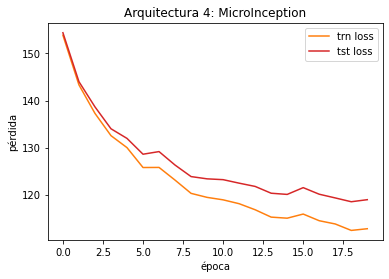

In [ ]:
trn_loss4, tst_loss4 = zip(*loss_hist4)
plt.plot(trn_loss4, 'tab:orange', label='trn loss')
plt.plot(tst_loss4, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.title('Arquitectura 4: MicroInception')
plt.show()

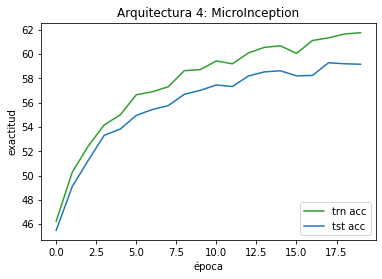

In [ ]:
trn_acc4, tst_acc4 = zip(*acc_hist4)
plt.plot(trn_acc4, 'tab:green', label='trn acc')
plt.plot(tst_acc4, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.title('Arquitectura 4: MicroInception')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss4, trn_acc4 = eval_epoch(trn_dl, model4)
# evaluamos en prueba
tst_loss4, tst_acc4 = eval_epoch(tst_dl, model4)
print(f'loss=[{trn_loss4:6.2f},{tst_loss4:6.2f}] '
      f'acc=[{trn_acc4:5.2f},{tst_acc4:5.2f}]')

loss=[112.79,118.83] acc=[61.75,59.20]


Finalmente, en este último intento apreciamos que con esta arquitectura tenemos el peor rendimiento en cuanto a accuracy y pérdida en comparándolo con los 3 intentos anteriores, aunque con menor sobreajuste que en los otros 3; aunque los resultados de la evaluación son similares a los de la primera arquitectura. No obstante, aquí hay menor cantidad de parámetros. Por lo que concierne a tiempo de ejecución, se tardó un poco menos que al utilizar 2 bloques.

### Conclusiones

De las ejecuciones anteriores podemos resumir a grandes rasgos que con la de MicroInception teníamos una peor accuracy y una peor pérdida, aunque al menos esta no se sobreajustaba significativamente. Por otro lado, utilizando 3 bloques fue la arquietctura con la que mejor rendimiento obtuvimos con los datos de entrenamiento. 

Tal vez con dos 2 bloques tomando en cuenta la información de los datos de entrenamiento y prueba del tiempo de ejecución, el accuracy y la pérdida, parece ser el más adecuado. 

Aquí también presentamos los resultados de la segunda arquitectura al utilizar como optimizador el SGD (manteniendo un learning rate de 1e-3):

<img src="https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/master/Figuras/T2/t2_e1_1.jpg" width="800"/>

<img src="https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/master/Figuras/T2/t2_e1_2.jpg" width="600"/>

<img src="https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/master/Figuras/T2/t2_e1_3.jpg" width="600"/>

<img src="https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/master/Figuras/T2/t2_e1_4.jpg" width="400"/>

Notamos que con este no tenemos un sobreajuste, aunque el accuracy es mucho más bajo que con el optimizador Adam.

Finalmente, de igual manera usando dos bloques (la segunda arquitectura de esta libreta) presentamos los resultados usando SGD como optimizador y un learning rate de 1e-5:


<img src="https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/master/Figuras/T2/t2_e1_5.jpg" width="800"/>

<img src="https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/master/Figuras/T2/t2_e1_6.jpg" width="600"/>

<img src="https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/master/Figuras/T2/t2_e1_7.jpg" width="600"/>

<img src="https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/master/Figuras/T2/t2_e1_8.jpg" width="400"/>

Vemos que es un pésimo modelo y además es peor que el que presentamos en la tarea 1. 

Por ello, siempre es importante probar con varios hiperparámetros y verificar que un 'pequeño' cambio puede modificar el rendimiento de un modelo. Esta es la razón por la que mostramos los resultados de las 4 arquitecturas usando Adam y un learning rate de 1e-3, ya que con estos encontré que había mejoras. 


Finalmente, realizamos predicciones utilizando la arquitectura 2 de esta libreta:

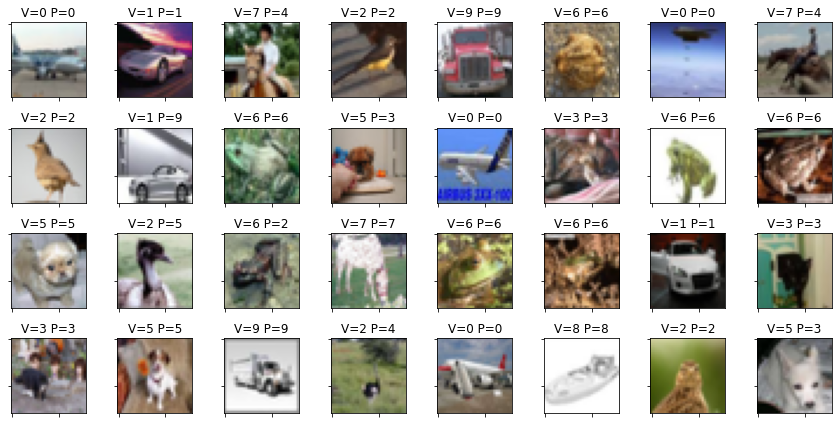

In [19]:
# inferencia

with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model2(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

Como podemos observar en las 32 imágenes anteriores, el modelo se equivocó en 8 de 32 ($\frac{32-8}{32} = 75.00\%$ de exactitud en las predicciones), y en el respectivo modelo de la tarea 1, se equivocaba en 20 de 32. Por lo tanto, logramos mejorar.
